# Infinite mixture model を Variational inferenceで

Variational inference でDirichlet process infinite mixture model をしたくなったので適当に[Lin 2013](http://papers.nips.cc/paper/4968-online-learning-of-nonparametric-mixture-models-via-sequential-variational)を見つけて読んで実装する.



## 1. Introduction

1. Dirichlet process mixture models(DPMM)はよい
    1. が,DPMMをMCMCで実現すると遅い. MCMCの手法は色々検討されているけど遅い. 大規模データに対して適用できない.
2. 平均場近似を用いたパラメータ推定法であるVariational inferenceを使うと, MCMCより高いパフォーマンスが出る
    1. 典型的なのはSBP(stick breaking process)を適当なコンポーネント数で打ち切る方法である(truncated-approximation).
    2. 適当なコンポーネント数は十分大きい必要があるので, 速いは速いが計算上の無駄が多い
3. 提案手法の特徴
    1. Variational inferenceと動的なコンポーネント数推定
    2. 逐次データに対応, online learning

## 2. Related Work

1. 効率的なBayesian nonparametric model の探求が流行っている. 
    1. Jain and Neal (2004) はsplit-merge で MCMCが局所解に停滞するのを避け高速化する手法を提案している.
    2. Dahl (2005) は 上のsequentiallyな実装を提案している(意味はわからん)
    3. この方向性の発展系としてHDP( Teh et al. (2007) )やBP-HMM( Hughes et al. (2012) )がある.
2. Variational inference はMCMCよりも高速. 中でもStochastic Variational Inference がすごい
    1. stochastic optimization(確率的最適化) と variational inference の合わせ技 Hoffman et al. (2012)
    2. Wang et al. (2011) がnon-parametricに拡張, Teh et al.(2007) が online-learning可能なHDPを提案
    3. Wang and Blei (2007)がtruncation-free variational inference を提案
3. Bryant and Sudderth (2012) online variational inference algorithm for HDP using mini-batch
    1. 本論文と似たような似たような問題意識
    2. 違いとして, Bryant and Sudderth (2012)はtopic model に特化している. こちらは汎用的.
    3. Bryant and Sudderth (2012)はランダムな初期値が必要. こちらは初期値不要
4. Nott et al. (2013) はVSUGSを提案している.
    1. 本論文に近いが, データの隠れ変数のみを推定している. 本論文は隠れ変数とコンポーネントのパラメタも推定している.
    2. Nott et al. (2013)はtruncation level Tってのが必要. 

## 3. Nonparametric Mixture Models

$$
D = \sum_{k=1}^{\infty}\pi_k\delta_{\phi_k}, \;
\operatorname{with} \pi_k = v_k\prod_{l=1}^{k-1}v_l, \;
v_k \propto \operatorname{Beta} \left( 1, \alpha_k\right), \;
\forall k = 1, 2, ... \tag{1} \\
$$

$$
D \propto DP\left( \alpha \mu\right), \;
\theta_i \propto \mu , \;
x_i \propto F\left( \cdot \mid \theta_i \right), \;
\forall i = 1, 2, ..., n \tag{2} \\
$$

$$
\begin{eqnarray}
z_{1:n} &\propto& \operatorname{CRP} \left( \alpha \right), \; \phi_k \propto \mu, \; \forall k = 1, 2, ... \\
x_{1:n} &\propto& F\left(\cdot \mid \phi_{z_i} \right), \; \forall i = 1, 2, ..., n  \tag{3}
\end{eqnarray}
$$

$$
p_{\operatorname {CRP}}\left( z_{1:n} \mid \alpha\right) =
\frac {\Gamma(\alpha) \alpha^K} {\Gamma(\alpha + n)} \prod_{k=1}^K \Gamma\left( | C_k| \right) \tag{4}
$$

## 4. Variational Approximation of Posterior

予測分布は以下のようになる.

$$
p\left( \theta'  \mid x_{1:n}\right) = \mathbb E_{D \mid x_{1:n}} \left\lbrack p\left( \theta' \mid D \right) \right\rbrack \tag {5}
$$

### 4.1. Posterior Analysis

$ D $ の事後分布.

$$
\begin{eqnarray}
D \mid \theta_{1:n} &\sim& \operatorname {DP} \left( \tilde {\alpha} \tilde {\mu}\right) \\
\tilde{\alpha} &=& \alpha + n \\
\tilde{\mu} &=& \frac {\alpha} {\alpha+n} \mu + \sum_{k=1}^K \frac {\left| C_k \right|} {\alpha + n} \delta_{\phi_k} \tag{6}
\end{eqnarray}
$$

$ p\left( D \mid z_{1:n}, x_{1:n} \right) $ からのサンプリングは以下のサンプリングと同じ.

$$
\begin{eqnarray}
\beta_0 D' + \sum_{k=1}^K \beta_k \delta_{\phi_k} , &&\\
&& with  \; D' \sim \operatorname {DP} \left( \alpha \mu  \right), \;
\left( \beta_0, \beta_1, ..., \beta_k \right) \sim \operatorname{Dir} \left( \alpha, m_1, ..., m_K \right), \;
\phi_k \sim \mu \mid _{C_k} \tag{7}
\end{eqnarray}
$$

ここで, $m_k = |C_k|$, $\mu \mid _{C_k}$ は 事後分布 $ \mu \mid _{C_k}\left( \operatorname d \theta \right) \propto \mu\left( \operatorname d \theta  \right) \prod_{i\in C_k} F \left( x_i \mid \theta \right)$

つまり$1:n$ までのデータが収まった中華料理店にもう１件データが追加された, という状態. $ \beta_k $ で既存のテーブルkに座り, $\beta_0$で新規テーブルが作られそこに座る. $\beta$の総和は1.

データ $ x_{1:n} $ が得られたときの混合分布 $ D $ の事後確率.

$$
p\left( D \mid x_{1:n} \right) = \sum_{z_{1:n}} p\left(z_{1:n} \mid x_{1:n} \right)p\left( D \mid x_{1:n}, z_{1:n}\right) \tag{8}
$$



$$
p \left( z_{1:n} \mid x_{1:n} \right)
\propto
    p_{\operatorname {CRP}} \left( z_{1:n} \mid \alpha \right)
    \prod_{k=1}^{K^{(z)}} \int \mu \left( \operatorname {d} \phi_{k} \right)
    \prod_{i \in C_k^{(z)}} F\left( x_i \mid \phi_k \right) \tag{9}
$$

## 4.2 Variational Approximation

(8)について, $p\left(z_{1:n} \mid x_{1:n} \right)$を因子分解可能とし, $ p\left( D \mid z_{1:n}, x_{1:n} \right) $ を(11)の確率過程で近似する.

$$
q\left(D \mid \rho, \nu \right) = \sum_{z_{1:n}} \prod_{i=1}^n \rho_i\left(z_i \right)q_{\nu}^{(z)}\left( D \mid z_{1:n}\right) \tag{10}
$$

$$
\begin{eqnarray}
q_{\nu}^{(z)} \left( D \mid z_{1:n}\right) \overset{d} {\sim} && \beta_0 D' + \sum_{k=1}^K\beta_k\delta{\phi_k} \\
&&with \; D' \sim \operatorname {DP} \left( \alpha \mu \right), \;
\left( \beta_0, \beta_1, ..., \beta_k \right) \sim \operatorname{Dir} \left( \alpha, m_1^{(z)}, ..., m_K^{(z)} \right), \;
\phi_k \sim \nu_k\tag{11}
\end{eqnarray}
$$

(10), (11)と(8), (9)はよく似ている. 違いは, 

1.  $p\left(z_{1:n} \mid x_{1:n} \right)$を因子分解可能とし, $ \prod_{i=1}^n \rho_i\left(z_i \right)$ で近似したこと
2.  $\mu |_{C_k}$ を $\nu_k$ で近似したこと 

$$
\mathbb E_{q\left( D \mid \rho, \nu  \right)}\left\lbrack p\left(\theta'  \mid D \right) \right\rbrack
=
    \frac {\alpha} {\alpha + n} \mu\left( \theta ' \right)
    + \sum_{k=1}^K \frac {\sum_{i=1}^n \rho_i\left( k \right)} {\alpha + n} \nu_k\left( \theta'\right) \tag{12}
$$

### 4.3 Sequential Approximation

$$
\tag{15}
\rho_{i+1} \propto \left\{ \begin{array}{ll}
    w_k^{(i)} \int_\theta F\left( x_{i+1} \mid \theta \right) \nu_k^{(i)} \left( d \theta \right) & (k \le K), \\
    \alpha \int_\theta F\left( x_{i+1} \mid \theta \right) \mu \left( d \theta \right) & (k = K+1), \\
  \end{array} \right.
$$

with $ w_i^{(i)} = \sum_{j=1}^i \rho_j\left(k \right)$, and 

$$
\tag{16}
\nu_{k}^{(i+1)}\left( d\theta \right) \propto \left\{ \begin{array}{ll}
    \mu\left( d\theta \right) \prod_{j=1}^{i+1} F\left( x_j \mid \theta \right)^{\rho_j(k)}
    & (k \le K), \\
    \mu\left( d\theta \right) F\left( x_{i+1} \mid \theta \right)^{\;\rho_{i+1}(k)}
    & (k = K+1), \\
  \end{array} \right.
$$

$\rho_1 = 1, K = 1$ から開始する, $i$を増やすたびに, $\rho_{i+1}$の計算, $w_k$ の更新, Kの更新, $\nu$の更新(, と$\rho$の更新も?)を繰り返す. Kをインクリメントするかどうかは, $\rho_{i+1}\left( K+1 \right) $ がしきい値以上であるか否かで判定する. Kをインクリメントしない場合は, $\rho_{i+1}\left( K+1 \right) $は不要なので削除, $\rho_{i+1}\left( 1,..., K \right) $の総和が1になるように標準化する.

## Normal-Wishart分布を基底分布にしてinfinite mixture multivariate normal modelを実装してみる.

多変量正規分布のInfinite mixture モデルを考える. 分布のパラメータとして, 平均と精度行列を推定する. Dirichlet Processの基底分布はNormal-Wishart分布.

$$
\begin{eqnarray}
\nu_k &=& \left(\boldsymbol \mu_k, \boldsymbol \Lambda_k \right) \sim
    \mathcal N \left(\boldsymbol \mu_{k} \mid \mathbf m_{0}, \left(\beta_{0} \boldsymbol \Lambda_{k} \right)^{-1}\right)
    \mathcal W\left(\boldsymbol \Lambda_{k} \mid \mathbf W_{0}, \nu_{0}\right)
\end{eqnarray}
$$

(16)の上の式を考える.

$$
\begin{eqnarray}
\mu\left( d\theta \right) \prod_{j=1}^{i+1} F\left( x_j \mid \theta \right)^{\rho_j(k)}
&=&
    \prod_{j=1}^{i+1}\mathcal N \left( x_{j} \mid \boldsymbol \mu_k, \boldsymbol \Lambda_k^{-1} \right)^{\;\rho_j(k)}
    \mathcal N \left(\boldsymbol \mu_{k} \mid \mathbf m_{0}, \left(\beta_{0} \boldsymbol \Lambda_{k} \right)^{-1}\right)
    \mathcal W\left(\boldsymbol \Lambda_{k} \mid \mathbf W_{0}, \nu_{0}\right)
\end{eqnarray}
$$

多変量正規分布+事前分布(Normal-Wishart分布)の形だが, データの尤度の肩に$\rho$が乗っている点が[以前解いたもの](http://kazufusa1484.hatenablog.com/entry/2018/07/27/121549)と異なっているが, 
$ \sum_{j=1}^{i+1}\rho_j\left(k\right) = r(k)と重み付け平均\overline {\mathbf x_k} = \sum_{j=1}^{i+1} \rho_j(k) \textbf x_j  / r(k) $ を導入して, 以前の導出の$N$を$r(k)$に置き換えるとよい.

$$
\begin{eqnarray}
q^{\ast}\left(\boldsymbol \mu_{k}, \boldsymbol \Lambda_{k} \right)
&=&
    \mathcal N\left(
        \boldsymbol \mu_{k} \mid \mathbf m_k, \left(\beta_{k} \boldsymbol \Lambda_{k} \right)^{-1}\right)
    \mathcal W\left(\boldsymbol \Lambda_{k} \mid \textbf W_{k}^{-1}, \nu_{k} \right) \\
\mathbf m_k &=& \frac {r(k)\overline {\textbf x_{k}} + \beta_0 \mathbf m_0} {r(k) + \beta_0} \\
\beta_k &=& r(k)+\beta_0 \\
\textbf W_k^{-1} &=&
    \textbf W_0^{-1}
    + \frac {r(k) \beta_0}{r(k)+\beta_0}
        \left(\overline {\textbf x_{k}} - \mathbf m_0\right)
        \left(\overline {\textbf x_{k}} - \mathbf m_0\right)^{\rm T}
    + \sum_{j=1}^{i+1} \rho_j(k)
        \left(\mathbf x_{j} - \overline{ \mathbf x_k}\right)
        \left(\mathbf x_{j} - \overline{ \mathbf x_k}\right)^{\rm T} \\
\nu_k &=& r(k) + \nu_0
\end{eqnarray}
$$

クラスタのパラメータの事後分布が得られた.

また, (16)の下の式は以下となる.

$$
\begin{eqnarray}
q^{\ast}\left(\boldsymbol \mu_{k}, \boldsymbol \Lambda_{k} \right)
&=&
    \mathcal N\left(
        \boldsymbol \mu_{k} \mid \mathbf m_k, \left(\beta_{k} \boldsymbol \Lambda_{k} \right)^{-1}\right)
    \mathcal W\left(\boldsymbol \Lambda_{k} \mid \textbf W_{k}^{-1}, \nu_{k} \right) \\
\mathbf m_k &=& \frac {\rho_{i+1}(k) \textbf x_{i+1} + \beta_0 \mathbf m_0} {\rho_{i+1}(k) + \beta_0} \\
\beta_k &=& \rho_{i+1}(k)+\beta_0 \\
\textbf W_k^{-1} &=&
    \textbf W_0^{-1}
    + \frac {\rho_{i+1}(k) \beta_0}{\rho_{i+1}(k)+\beta_0}
        \left({\textbf x_{i+1}} - \mathbf m_0\right)
        \left({\textbf x_{i+1}} - \mathbf m_0\right)^{\rm T}\\
\nu_k &=& \rho_{i+1}(k) + \nu_0
\end{eqnarray}
$$

(15)の$k \le K$ の場合.


$$
\begin{eqnarray}
w_k^{(i)} \int_\theta F\left( x_{i+1} \mid \theta \right) \nu_k^{(i)} \left( d \theta \right)
&=&
    w_k^{(i)} \int
        p\left( \mathbf x_{i+1} \mid \boldsymbol \mu_k, \boldsymbol \Lambda_k \right)
        p\left( \boldsymbol \mu_k, \boldsymbol \Lambda_k \right)
    \operatorname d \boldsymbol \mu_k \operatorname d \boldsymbol \Lambda_k \\
&=&
    w_k^{(i)}
    \operatorname {St} \left(
        \mathbf x_{i+1}
        \; \middle| \;
        \boldsymbol \mu_k, 
        \frac {\beta_k\left(\nu_k + 1 - D\right)}{1+\beta_k}\textbf W_k,
        \nu_k + 1 - D
    \right)
\end{eqnarray}
$$

(15)の$k = K+1$の場合.

まず$\mathbf x_{i+1}$ が得られたときのパラメータの事後分布を求める.

$$
\begin{eqnarray}
p\left(\boldsymbol \mu, \boldsymbol \Lambda \mid \mathbf x_{i+1} \right)
&=&
    \mathcal N\left(
        \boldsymbol \mu \mid \mathbf m_1, \left(\beta_1 \boldsymbol \Lambda_1 \right)^{-1}\right)
    \mathcal W\left(\boldsymbol \Lambda_{1} \mid \textbf W_{1}^{-1}, \nu_1 \right) \\
\mathbf m_1 &=& \frac {\textbf x_{i+1} + \beta_0 \mathbf m_0} {1 + \beta_0} \\
\beta_1 &=& 1+\beta_0 \\
\textbf W_1^{-1} &=&
    \textbf W_0^{-1}
    + \frac {\beta_0}{1+\beta_0}
        \left({\textbf x_{i+1}} - \mathbf m_0\right)
        \left({\textbf x_{i+1}} - \mathbf m_0\right)^{\rm T}\\
\nu_1 &=& 1 + \nu_0
\end{eqnarray}
$$

これをもとに(15)の下の式を変形する.

$$
\begin{eqnarray}
\alpha \int_\theta F\left( x_{i+1} \mid \theta \right) \mu \left( d \theta \right)
&=&
    \alpha \int
        p\left( \mathbf x_{i+1} \mid \boldsymbol \mu, \boldsymbol \Lambda \right)
        p\left( \boldsymbol \mu, \boldsymbol \Lambda \right)
    \operatorname d \boldsymbol \mu \operatorname d \boldsymbol \Lambda \\
&=&
    \alpha \int
        p\left( \mathbf x_{i+1} \right)
    \operatorname d \boldsymbol \mu \operatorname d \boldsymbol \Lambda \\
&=&
    \alpha \times p\left( \mathbf x_{i+1} \right) \\
&=&
    \alpha \frac {1} {\pi^{\frac {D} {2}}}
    \frac {\Gamma _{D}\left({\frac {\nu_1}{2}}\right)} {\Gamma _{D}\left({\frac {\nu_0}{2}}\right)}
    \frac {\left|{\mathbf {W}_1 }\right|^{\frac {\nu_1} {2}}} {\left|{\mathbf {W}_0 }\right|^{\frac {\nu_0} {2}}}
    \left(\frac {\beta_0} {\beta_1}\right)^{\frac {D} {2}}
\end{eqnarray}
$$

ここで, 

$$
{\displaystyle \Gamma _{D}\left({\frac {n}{2}}\right)=\pi ^{D(D-1)/4}\prod _{j=1}^{D}\Gamma \left({\frac {n-j+1}{2}}\right).}
$$

なので,

$$
\begin{eqnarray}
\frac
    {\Gamma_D\left( \frac {\nu_1} {2} \right)}
    {\Gamma_D\left( \frac {\nu_0} {2} \right)}
&=&
    \frac
    {\prod^D_{j=1}\Gamma \left( \frac {\nu_1 - j + 1} {2}\right)}
    {\prod^D_{j=1}\Gamma \left( \frac {\nu_0 - j + 1} {2}\right)} \\
&=&
    \frac
    {\prod^D_{j=1}\Gamma \left( \frac {\nu_0 - j + 2} {2}\right)}
    {\prod^D_{j=1}\Gamma \left( \frac {\nu_0 - j + 1} {2}\right)} \\
&=&
    \frac
    {\Gamma \left( \frac {\nu_0 +1} {2}\right)}
    {\Gamma \left( \frac {\nu_0 -D + 1} {2}\right)} \\
\end{eqnarray}
$$

よって,

$$
\begin{eqnarray}
\alpha \int_\theta F\left( x_{i+1} \mid \theta \right) \mu \left( d \theta \right)
&=&
    \alpha \frac {1} {\pi^{\frac {D} {2}}}
    \frac
        {\Gamma \left( \frac {\nu_0 +1} {2}\right)}
        {\Gamma \left( \frac {\nu_0 -D + 1} {2}\right)} 
    \frac {\left|{\mathbf {W}_1 }\right|^{\frac {\nu_1} {2}}} {\left|{\mathbf {W}_0 }\right|^{\frac {\nu_0} {2}}}
    \left(\frac {\beta_0} {\beta_1}\right)^{\frac {D} {2}}
\end{eqnarray}
$$

以上、全部導出できた.

In [427]:
import numpy as np
import scipy as sp
from scipy import stats
from scipy import special

import pandas as pd
pd.set_option('display.width', 200)
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import os
import subprocess
import warnings
warnings.filterwarnings('ignore')

from IPython.html.widgets import FloatProgress
from IPython.display import display

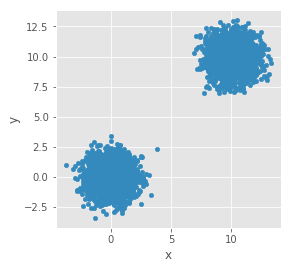

In [421]:
np.random.seed(0)
mean0 = np.array([0, 0])
cov0 = np.array([[1,0],[0,1]])
mean1 = np.array([10, 10])
cov1 = np.array([[1,0],[0,1]])
N = 5000
a = 0.5
X = pd.DataFrame(
    np.r_[
        sp.random.multivariate_normal(mean0, cov0, int(N*(1-a))),
        sp.random.multivariate_normal(mean1, cov1, int(N*a))
    ],
    columns=['x', 'y']
)
X.plot(kind='scatter', x='x', y='y').set_aspect('equal')
plt.savefig('1.png', bbox_inches='tight', pad_inches=0)

In [422]:
np.random.seed(0)
x = X.sample(frac=1).values.T
D = 2

# Dirichlet process base distribution
beta_0 = 1
m_0 = np.zeros((D, 1))
# m_0 = x[:, 0].reshape(D, 1)
W_0 = np.diag([1, 1])
nu_0 = 1.1

# Dirichlet process scaling parameter
alpha = 1

In [343]:
def init():
    global mu_k, W_k, nu_k, beta_k, rho, K
    maxK = 100
    mu_k = np.zeros((maxK, D, 1))
    W_k = np.zeros((maxK, D, D))
    nu_k = np.zeros(maxK)
    beta_k = np.zeros(maxK)
    rho = np.zeros((N, maxK))

    K = 1
    rho[0, 0] = 1

init()

In [6]:
# PDF of student's t distribution
def t_pdf(x, m, Lambda, df):
    D = len(m)
    if len(x) != D:
        m = m.reshape(D, 1)
        x = x.T

    return np.diag(
        sp.special.gamma(D/2. + df/2.) /
        sp.special.gamma(df/2.) *
        np.power(np.linalg.det(Lambda), 1/2.) / 
        np.power(np.pi * df, D/2.) *
        np.power(1 + (x-m).T@Lambda@(x-m)/df, -(D+df)/2.)
    )

In [7]:
# eq15( k le K)
def eq15_1(w, D, x, mu_k, beta_k, nu_k, W_k):
    return w * t_pdf(
        x,
        mu_k,
        beta_k * (nu_k + 1 - D) * W_k / (1 + beta_k),
        (nu_k + 1 - D)
    )

# eq15(k = K + 1)
def eq15_2(alpha, D, x, m_0, beta_0, nu_0, W_0):
    m_1 = (x + beta_0 * m_0) / (1 + beta_0)
    beta_1 = 1 + beta_0
    W_1_inv = np.linalg.inv(W_0) + beta_0 / (1 + beta_0) * (x - m_0)@(x-m_0).T
    W_1 = np.linalg.inv(W_1_inv)
    nu_1 = 1 + nu_0
    
    return alpha / np.power(np.pi, D/2.) \
        * sp.special.gamma((nu_0+1.)/2.) \
        / sp.special.gamma((nu_0+1.-D)/2.) \
        * np.power(np.linalg.det(W_1), nu_1/2.) \
        / np.power(np.linalg.det(W_0), nu_0/2.) \
        * np.power(beta_0/beta_1, D/2.)

In [20]:
# eq.16(k .le. K)
def eq16_1(x, rho, i, k, m_0, beta_0, nu_0, W_0):
    r_k = rho[0:i+1, k].sum()

    x_bar = x@rho[0:i+1, k:k+1] / r_k
    S_k = np.sum([rho[j, k] * (x[:,j:j+1] - x_bar)@(x[:,j:j+1] - x_bar).T for j in range(i+1)], axis=0)
    
    m_k = (r_k * x_bar + beta_0 * m_0) / (r_k + beta_0)
    beta_k = r_k + beta_0
    W_k_inv = np.linalg.inv(W_0) \
        + r_k * beta_0 / (r_k + beta_0) * (x_bar - m_0)@(x_bar - m_0).T \
        + S_k
    W_k = np.linalg.inv(W_k_inv)
    nu_k = r_k + nu_0
    
    return m_k, beta_k, W_k, nu_k

# eq.16(k = K + 1)
def eq16_2(x, rho, i, k, m_0, beta_0, nu_0, W_0):
    m_k = (rho[i, k] * x + beta_0 * m_0) / (rho[i, k] + beta_0)
    beta_k = rho[i, k] + beta_0
    W_k_inv = np.linalg.inv(W_0) \
        + rho[i, k] * beta_0 / (rho[i, k] + beta_0) * (x - m_0)@(x - m_0).T
    W_k = np.linalg.inv(W_k_inv)
    nu_k = rho[i, k] + nu_0
    
    return m_k, beta_k, W_k, nu_k

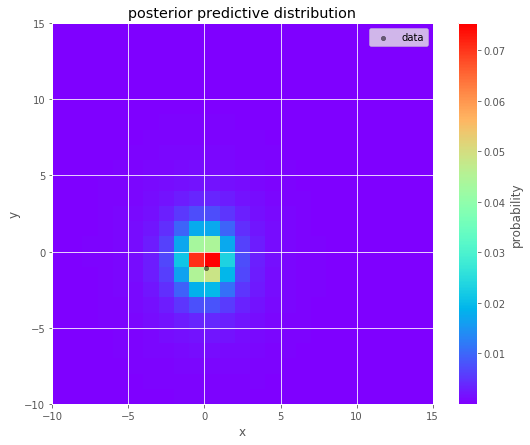

In [423]:
init()
i=0
k=0
_mu_k, _beta_k, _W_k, _nu_k = eq16_2(x[:,i:i+1], rho, i, k, m_0, beta_0, nu_0, W_0)

fig, ax = plt.subplots(ncols=1, figsize=(9, 7))

ax.set_aspect('equal')
ax.set_title('posterior predictive distribution')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')

delta = 1
xrange = np.array([-10, 15])
yrange = np.array([-10, 15])
gx = np.arange(*(xrange + delta/2), delta)
gy = np.arange(*(yrange + delta/2), delta)
gxx, gyy = np.meshgrid(gx, gy)
gxgy = np.c_[gxx.ravel(), gyy.ravel()]

# parameters of posterior predictive distribution
zz = t_pdf(
    gxgy,
    m_0,
    beta_0 * (nu_0 + 1 - D) * W_0 / (1 + beta_0),
    (nu_0 + 1 - D)
)
zz = t_pdf(
    gxgy,
    _mu_k,
    _beta_k * (_nu_k + 1 - D) * _W_k / (1 + _beta_k),
    (_nu_k + 1 - D)
)

im = ax.imshow(
    zz.reshape(len(gx), len(gy)), 
    interpolation='none', 
    origin='lower',
    extent=list(xrange) + list(yrange),
    cmap=matplotlib.cm.rainbow
)
fig.colorbar(im, ax=ax).set_label('probability')
pd.DataFrame(x[:, 0].reshape(1, D), columns=['x', 'y']) \
    .plot(kind='scatter', x='x', y='y', c='black', ax=ax, label='data', alpha=0.5);

In [27]:
## fig, ax = plt.subplots(ncols=1, figsize=(9, 7))

def plot(x=pd.DataFrame()):
    delta = 0.5
    xrange = np.array([-10, 15])
    yrange = np.array([-10, 15])
    gx = np.arange(*(xrange + delta/2), delta)
    gy = np.arange(*(yrange + delta/2), delta)
    gxx, gyy = np.meshgrid(gx, gy)
    gxgy = np.c_[gxx.ravel(), gyy.ravel()]

    fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
    for k in range(K):
        zz = t_pdf(
            gxgy,
            mu_k[k],
            beta_k[k] * (nu_k[k] + 1 - D) * W_k[k] / (1 + beta_k[k]),
            (nu_k[k] + 1 - D)
        )

        cs = ax.contour(gxx, gyy, zz.reshape(len(gx), len(gy)))
        plt.clabel(cs, inline=1, fontsize=10)
    if not x.empty:
        x.plot(kind='scatter', x='x', y='y', ax=ax, color='red', alpha=0.5).set_aspect('equal')

FloatProgress(value=1.0, max=4999.0, min=1.0)

26


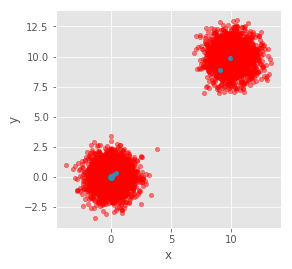

In [428]:
init()
i=0
k=0
alpha = 1
_mu_k, _beta_k, _W_k, _nu_k = eq16_2(x[:,i:i+1], rho, i, k, m_0, beta_0, nu_0, W_0)

mu_k[k] = _mu_k
beta_k[k] = _beta_k
W_k[k] = _W_k
nu_k[k] = _nu_k

fp = FloatProgress(min=1, max=N-1)
display(fp)
for i in np.arange(1, N):
    for k in np.arange(K):
        w = rho[0:i, k].sum()
        rho[i, k] = eq15_1(w, D, x[:,i:i+1], mu_k[k], beta_k[k], nu_k[k], W_k[k])
    rho[i, K] = eq15_2(alpha, D, x[:,i:i+1], m_0, beta_0, nu_0, W_0)
    rho[i, 0:K+1] = rho[i, 0:K+1] / rho[i, 0:K+1].sum()
    
    if rho[i, K] > 0.01:
        for k in np.arange(K):
            _mu_k, _beta_k, _W_k, _nu_k = eq16_1(x[:,0:i+1], rho, i, k, m_0, beta_0, nu_0, W_0)
            mu_k[k] = _mu_k
            beta_k[k] = _beta_k
            W_k[k] = _W_k
            nu_k[k] = _nu_k
        
        _mu_k, _beta_k, _W_k, _nu_k = eq16_2(x[:,i:i+1], rho, i, K, m_0, beta_0, nu_0, W_0)
        mu_k[K] = _mu_k
        beta_k[K] = _beta_k
        W_k[K] = _W_k
        nu_k[K] = _nu_k
        
        K = K + 1
    else:
        rho[i, K] = 0
        rho[i, 0:K] = rho[i, 0:K] / rho[i, 0:K].sum()
        for k in np.arange(K):
            _mu_k, _beta_k, _W_k, _nu_k = eq16_1(x[:,0:i+1], rho, i, k, m_0, beta_0, nu_0, W_0)
            mu_k[k] = _mu_k
            beta_k[k] = _beta_k
            W_k[k] = _W_k
            nu_k[k] = _nu_k
    # plot(pd.DataFrame(x[:,:i+1].T, columns=['x', 'y']))
    fp.value = i

print(K)
ax = X.plot(kind='scatter', x='x', y='y', color='red', alpha=0.5)
pd.DataFrame(mu_k.reshape(100, 2)[0:K], columns=['x','y']).plot(kind='scatter', x='x', y='y', ax=ax).set_aspect('equal')

In [429]:
print(rho.sum(axis=0)[0:K]/100)

[2.37889715e+01 1.68688434e+00 4.14672861e-04 1.16562568e+01
 1.28317469e+01 1.92121833e-02 5.58122531e-03 2.24000876e-04
 1.35105708e-03 1.98841954e-03 1.33079086e-03 9.94981506e-04
 5.91432211e-04 4.14082026e-04 6.45743571e-04 5.15290864e-04
 2.70207038e-04 2.94882045e-04 2.62372507e-04 2.50728790e-04
 4.13811568e-04 2.06258165e-04 3.28682038e-04 4.60045064e-04
 1.66639475e-04 2.23002031e-04]


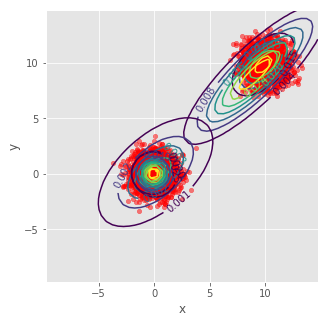

In [431]:
K = 5
plot(pd.DataFrame(x[:, 0:i].T, columns=['x', 'y']))

データに一度割り当てた $ \rho $ が以降更新されないことは問題だと思う. データが増えて生成された新規コンポーネントに, それ以前のデータは寄与できない. これにより推定結果は添字の若いデータやその並び順に依存する.
それでも十分に大量のデータがある場合にそれなりにうまく行くようだ.

論文によれば各イテレーションにおいてprune(weightの小さいコンポーネントを削除) and merge(各データにおける負担率の分布が近いコンポーネントをmerge)するともっと良くなるらしい. mergeは実質 すべての$ \rho $ を更新する手続きである.

In [460]:
# test merge
K = 26
for i in range(K-1):
    for j in range(i+1, K):
        diff = np.abs(rho[:, i] - rho[:, j]).sum() / N
        # print(i, j, diff)

In [409]:
#[[8.92942262]
# [8.8773688 ]] 342.58217572070873 342.68217572070876 [[ 0.00185455 -0.00173809]
# [-0.00173809  0.00190695]]
i = 617

# eq15( k le K)
def eq15_1(w, D, x, mu_k, beta_k, nu_k, W_k):
    return w * t_pdf(
        x,
        mu_k,
        beta_k * (nu_k + 1 - D) * W_k / (1 + beta_k),
        (nu_k + 1 - D)
    )
# PDF of student's t distribution
def t_pdf(x, m, Lambda, df):
    D = len(m)
    if len(x) != D:
        m = m.reshape(D, 1)
        x = x.T

    return np.diag(
        np.exp(sp.special.loggamma(D/2. + df/2.) - sp.special.loggamma(df/2.)) *
        np.power(np.linalg.det(Lambda), 1/2.) / 
        np.power(np.pi * df, D/2.) *
        np.power(1 + (x-m).T@Lambda@(x-m)/df, -(D+df)/2.)
    )
_mu_k = np.array([[8.92942262], [8.8773688 ]])
_beta_k = 342.58217572070873
_nu_k = 342.68217572070876
_W_k = np.array([[ 0.00185455,-0.00173809],[-0.00173809,0.00190695]])
eq15_1(1, D, x[:,i:i+1], _mu_k, _beta_k, _nu_k, _W_k)

array([0.00012023])